In [5]:
from src.dataset import get_raw_training_data, get_raw_testing_data, get_labels
from src.spacy_helper import format_data_as_spacy, get_spacy_model, train, predict

from src.metrics import score
from src.visualization import plot_confusion_matrix

import numpy as np
import time

In [6]:
raw_training_data = get_raw_training_data('./data/training_set.json')
raw_testing_data = get_raw_testing_data('./data/testing_set.json')

labels = get_labels(raw_training_data)

y_true = [r['intent'] for r in raw_testing_data]
y_true_t = [r['intent'] for r in raw_training_data]

X_train, y_train = format_data_as_spacy(raw_training_data)
X_test, y_test = format_data_as_spacy(raw_testing_data)


model = get_spacy_model(labels)

model = train(model, X_train, y_train)
model.to_disk(f"./model")

Training the model...
Iteration 0/10. train_loss: 16.551815514001646
Iteration 1/10. train_loss: 1.0702361922012642
Iteration 2/10. train_loss: 0.2370441952298279
Iteration 3/10. train_loss: 0.07989519134389411
Iteration 4/10. train_loss: 0.03996131539315684
Iteration 5/10. train_loss: 0.026344511046772823
Iteration 6/10. train_loss: 0.02249543910011198
Iteration 7/10. train_loss: 0.01972961108549498
Iteration 8/10. train_loss: 0.016199148825876364
Iteration 9/10. train_loss: 0.014727040683283121


In [7]:
y_pred = predict(model, X_test)
y_pred_t = predict(model, X_train)

In [8]:
training_results = score(y_true_t, y_pred_t)
testing_results = score(y_true, y_pred)

In [9]:
print(testing_results['report'])

                   precision    recall  f1-score   support

   find-around-me       0.55      0.57      0.56        67
      find-flight       0.83      0.83      0.83        24
       find-hotel       0.75      0.80      0.77        55
  find-restaurant       0.85      0.81      0.83        93
       find-train       0.65      0.81      0.72        21
       irrelevant       0.92      0.89      0.90       677
provide-showtimes       0.71      0.86      0.77        14
         purchase       0.73      0.79      0.76       114

         accuracy                           0.85      1065
        macro avg       0.75      0.79      0.77      1065
     weighted avg       0.85      0.85      0.85      1065



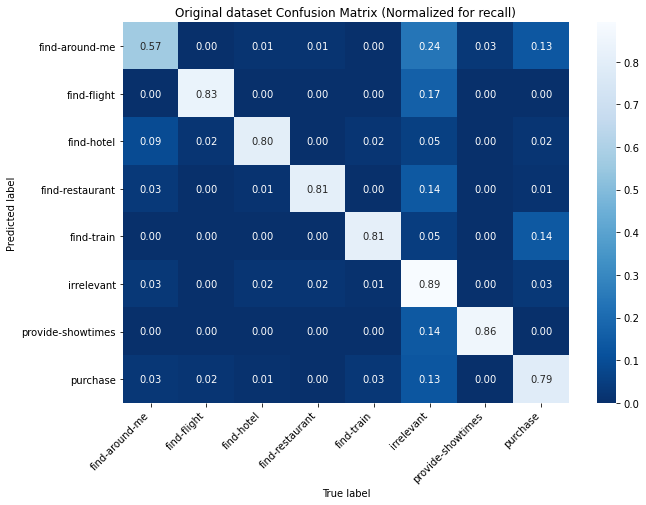

In [10]:
cm_testing_metrics = np.array(testing_results['cm'], dtype='float64')
for i in range(len(cm_testing_metrics)):
    cm_testing_metrics[i] = cm_testing_metrics[i] / np.sum(cm_testing_metrics[i])
plot_confusion_matrix(cm_testing_metrics, labels, title="Original dataset Confusion Matrix (Normalized for recall)", fmt=".2f")

In [11]:
print(training_results['report'])

                   precision    recall  f1-score   support

   find-around-me       0.96      0.97      0.96       383
      find-flight       0.97      0.99      0.98       142
       find-hotel       0.95      0.98      0.97       316
  find-restaurant       0.97      0.99      0.98       469
       find-train       0.97      0.99      0.98       143
       irrelevant       1.00      0.98      0.99      3852
provide-showtimes       0.97      0.99      0.98       117
         purchase       0.96      0.99      0.98       613

         accuracy                           0.99      6035
        macro avg       0.97      0.99      0.98      6035
     weighted avg       0.99      0.99      0.99      6035



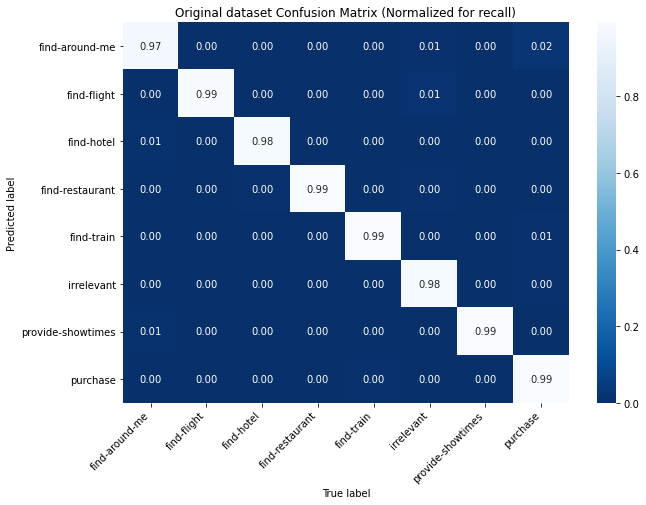

In [12]:
cm_testing_metrics = np.array(training_results['cm'], dtype='float64')
for i in range(len(cm_testing_metrics)):
    cm_testing_metrics[i] = cm_testing_metrics[i] / np.sum(cm_testing_metrics[i])
plot_confusion_matrix(cm_testing_metrics, labels, title="Original dataset Confusion Matrix (Normalized for recall)", fmt=".2f")